In [1]:
%%capture null
!PIP_REQUIRE_VIRTUALENV=0  pip install -r requirements.txt

In [2]:
import warnings

warnings.filterwarnings("ignore")

# Initial Study

This notebook identifies PPMI subjects to reproduce the following paper:

<div class="alert alert-block alert-success">
   	E. Mak et al., <a href="https://www.sciencedirect.com/science/article/pii/S0197458017300830"> “Longitudinal whole-brain atrophy and ventricular enlargement in nondemented Parkinson’s disease”</a>, Neurobiology of aging, vol. 55, pp. 78–90, 2017.
</div>

This study included PD subjects ($n=104$) and healthy controls ($n=38$) who completed a baseline and and follow-up T1 MRI at 18 months.
The demographic of the studied population was as follow (table extracted from the paper).

<div><img src="figures/table1.png" width="1200px"></div>



In [3]:
# TODO
# - Brief summary of image analysis to be reproduced
# - Key results to be reproduced

In [4]:
from IPython.display import HTML

HTML(
    """<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the Python code."></form>"""
)

In [5]:
import datetime

import pytz

now = datetime.datetime.now(pytz.utc).strftime("%Y-%m-%d %H:%M:%S %Z %z")
print(f"This notebook was run on {now}")

This notebook was run on 2022-07-07 19:45:37 UTC +0000


# PPMI Metadata Download

We download metadata file from the PPMI database, using [`ppmi-downloader`](https://pypi.org/project/ppmi-downloader/) available on PyPi.
</br>Your PPMI credentials will be asked before download.

In [6]:
import os

import ppmi_downloader


ppmi = ppmi_downloader.PPMIDownloader()

data_dir = os.path.join(os.getcwd(), "data")

if not os.path.exists(data_dir):
    os.makedirs(data_dir, mode=0o755, exist_ok=True)

required_files = [
    "Demographics.csv",
    "Age_at_visit.csv",
    "MDS_UPDRS_Part_III.csv",
    "Socio-Economics.csv",
    "Montreal_Cognitive_Assessment__MoCA_.csv",
    "PD_Diagnosis_History.csv",
    "Cognitive_Categorization.csv",
]

missing_metadata = [
    filename
    for filename in required_files
    if not os.path.exists(os.path.join(data_dir, filename))
]

if missing_metadata:
    ppmi.download_metadata(
        missing_metadata,
        destination_dir=data_dir,
        headless=True,
        timeout=600,
    )

## Download LivingPark utility notebook

Here below, we download and execute utility notebook from the LivingPark project.
</br>These notebook will create cleaned up metadate file needed throughout this notebook.

In [7]:
%%capture null
import httpx

livingPark_notebooks = {
    "clean_pdstate.ipynb": "https://raw.githubusercontent.com/LivingPark-MRI/ppmi-treatment-and-on-off-status/main/PPMI%20medication%20and%20ON-OFF%20status.ipynb",
    "clean_mri_metadata.ipynb": "https://raw.githubusercontent.com/LivingPark-MRI/ppmi-MRI-metadata/main/MRI%20metadata.ipynb",
}

if not os.path.exists("utils"):
    os.makedirs("utils", mode=0o755, exist_ok=True)

for filename, url in livingPark_notebooks.items():

    filepath = os.path.join("utils", filename)
    if not os.path.exists(filepath):
        r = httpx.get(url)
        with open(filepath, "wb") as fout:
            fout.write(r.content)

        %run "{filepath}"

# Cohort Matching

## Utils

In [8]:
from collections import defaultdict
from itertools import combinations
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams["figure.figsize"] = (16, 8)

In [9]:
visit2month = {
    "BL": 0,
    "V01": 3,
    "V02": 6,
    "V03": 9,
    "V04": 12,
    "V05": 18,
    "V06": 24,
    "V07": 30,
    "V08": 36,
    "V09": 42,
    "V10": 48,
    "V11": 54,
    "V12": 60,
    "V13": 72,
    "V14": 84,
    "V15": 96,
    "V16": 108,
    "V17": 120,
    "V18": 132,
    "V19": 144,
    "V20": 156,
}


def find_visit_pairs(months: int) -> int:
    """Return the pairs of visits closest to each other, given a target time difference in months."""

    diff = float("inf")
    diff_hist = defaultdict(dict)

    for (k, v), (k_, v_) in combinations(visit2month.items(), 2):
        if (diff_ := abs(abs(v - v_) - months)) <= diff:
            diff = diff_
            diff_hist[diff][k] = k_

    return diff_hist[diff]

In [10]:
def reformat_plot_labels(dist, ax, freq):
    ax.set_xticklabels([x.removesuffix(".0") for x in dist.index.astype(str)])
    for label in ax.xaxis.get_ticklabels():
        try:
            if int(label.get_text()) % freq != 0:
                label.set_visible(False)
        except:
            pass

In [11]:
def moca2mmse(moca_score):
    """Return a MMSE score given a MoCA score."""
    mapping = {
        1: 6,
        2: 9,
        3: 11,
        4: 12,
        5: 13,
        6: 14,
        7: 15,
        8: 15,
        9: 16,
        10: 17,
        11: 18,
        12: 18,
        13: 19,
        14: 20,
        15: 21,
        16: 22,
        17: 22,
        18: 23,
        19: 24,
        20: 25,
        21: 26,
        22: 26,
        23: 27,
        24: 28,
        25: 28,
        26: 29,
        27: 29,
        28: 30,
        29: 30,
        30: 30,
    }

    try:
        if math.isnan(moca_score):
            return np.nan
        else:
            return mapping[moca_score]
    except:
        return moca_score

## Data preparation

### Cognitive state

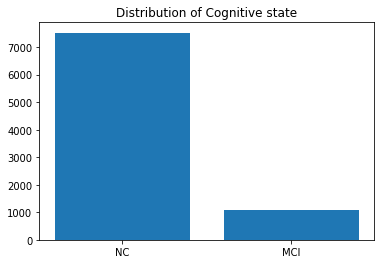

In [12]:
cog_state = pd.read_csv(os.path.join(data_dir, "Cognitive_Categorization.csv"))[
    ["PATNO", "EVENT_ID", "COGSTATE"]
]
cog_state = cog_state[cog_state["COGSTATE"] != 3]  # Drop all cases of PDD

fig, ax = plt.subplots()
dist = cog_state.groupby(["COGSTATE"]).size()
plt.bar(dist.index.astype(str), dist.values)
plt.title("Distribution of Cognitive state")

reformat_plot_labels(dist, ax, 1)
ax.set_xticklabels(["NC", "MCI"]);

We observe that NC subjects account for a majority of the PPMI cohort.
</br>Therefore, in our following steps, we will focus on obtaining MCI subjects before NC ones.

### Diseases duration

In [13]:
pddxdt = pd.read_csv(os.path.join(data_dir, "PD_Diagnosis_History.csv"))[
    ["PATNO", "EVENT_ID", "PDDXDT"]
]
pddxdt.groupby("EVENT_ID").size()

EVENT_ID
BL        4
SC     1182
V04       1
dtype: int64

We will only use the PD diagnosis duration taken at screening since it is by far the most frequent.

In [14]:
from dateutil.parser import parse
from dateutil.relativedelta import relativedelta

pddxdt = pddxdt[(pddxdt["EVENT_ID"] == "SC") & pddxdt["PDDXDT"].notna()]

pdxdur = pd.read_csv(
    os.path.join(data_dir, "MDS_UPDRS_Part_III.csv"), low_memory=False
)[["PATNO", "EVENT_ID", "INFODT"]]

PDDXDT_map = dict(zip(pddxdt["PATNO"].values, pddxdt["PDDXDT"].values))
pdxdur["PDDXDT"] = pdxdur["PATNO"].map(PDDXDT_map)

pdxdur["PDXDUR"] = pdxdur.apply(
    lambda row: relativedelta(parse(row["INFODT"]), parse(row["PDDXDT"])).months
    if row["PDDXDT"] is not np.nan
    else np.nan,
    axis=1,
)
pdxdur.drop(labels=["INFODT", "PDDXDT"], inplace=True, axis=1);

### MRI availability

In [15]:
mri = pd.read_csv(os.path.join(data_dir, "MRI_info.csv"))
mri["EVENT_ID"] = mri["Visit code"]
mri["PATNO"] = mri["Subject ID"]
mri["Sex"] = mri["Sex"].map({"F": 0, "M": 1})
mri = mri.drop(
    ["Subject ID", "Visit code", "Visit", "Age", "Sex", "Description"], axis=1
)
mri.groupby("EVENT_ID").size().sort_values(ascending=False).head(5)

EVENT_ID
BL     1148
V10     355
V06     324
V04     274
ST       10
dtype: int64

The only visits with enough MRI available to replicate the study are: BL (baseline), V04, V06, and V10. Therefore we will only consider these visits.

### Examination scores

#### Hoehn and Yahr (H&Y)

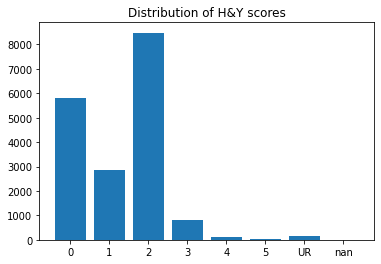

In [16]:
updrs3 = pd.read_csv(os.path.join(data_dir, "MDS_UPDRS_Part_III_clean.csv"))[
    ["PATNO", "EVENT_ID", "PDSTATE", "PDTRTMNT", "NP3TOT", "NHY"]
]
dist = updrs3.groupby(["NHY"], dropna=False).size()

plt.bar(dist.index.astype(str), dist.values)
plt.title("Distribution of H&Y scores");

We remove the subjects which clinicians were unable to rate the H&Y score (UR)

In [17]:
updrs3 = updrs3[updrs3["NHY"] != "UR"]
updrs3["NHY"] = pd.to_numeric(updrs3["NHY"])

#### Unified Parkinso's Disease Rating Scale, Part III (UDPRS III)

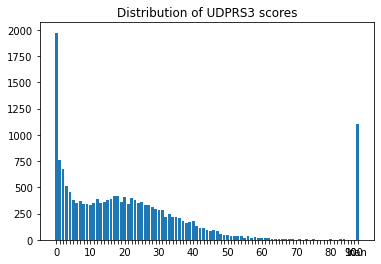

In [18]:
fig, ax = plt.subplots()
dist = updrs3.groupby(["NP3TOT"], dropna=False).size()
plt.bar(dist.index.astype(str), dist.values)
plt.title("Distribution of UDPRS3 scores")

reformat_plot_labels(dist, ax, 10)

#### Montreal Cognitive Assessment (MoCA)

Due to the low amount of MRI availability at baseline, we consider the MoCA scores at screening as substitute for baseline.

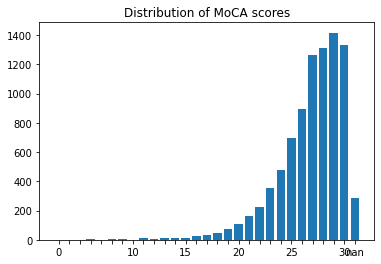

In [19]:
moca = pd.read_csv(os.path.join(data_dir, "Montreal_Cognitive_Assessment__MoCA_.csv"))[
    ["PATNO", "EVENT_ID", "MCATOT"]
]

# Use screening instead of baseline.
moca = moca[moca["EVENT_ID"] != "BL"]
moca["EVENT_ID"].mask(moca["EVENT_ID"] == "SC", "BL", inplace=True)

fig, ax = plt.subplots()
dist = moca.groupby(["MCATOT"], dropna=False).size()
plt.bar(dist.index.astype(str), dist.values)
plt.title("Distribution of MoCA scores")

reformat_plot_labels(dist, ax, 5)

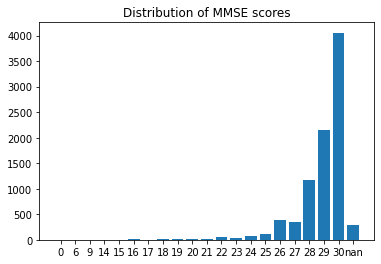

In [20]:
moca["MMSETOT"] = moca["MCATOT"].apply(moca2mmse)

fig, ax = plt.subplots()
dist = moca.groupby(["MMSETOT"], dropna=False).size()
plt.bar(dist.index.astype(str), dist.values)
plt.title("Distribution of MMSE scores")

reformat_plot_labels(dist, ax, 1)

### Demographics

#### Sex

In [21]:
demo = pd.read_csv(os.path.join(data_dir, "Demographics.csv"))[["PATNO", "SEX"]]
demo["SEX"] = demo["SEX"].astype(int)
print("Distribution of Sex")
demo.groupby("SEX").size().rename({0: "Female", 1: "Male"})

Distribution of Sex


SEX
Female     964
Male      1306
dtype: int64

#### Age at visit

We consider the age at specific visits. However for simplicity, we only plot the age distribution at baseline.

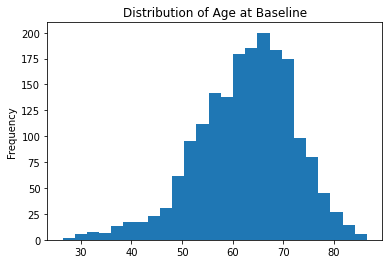

In [22]:
age = pd.read_csv(os.path.join(data_dir, "Age_at_visit.csv"))[
    ["PATNO", "EVENT_ID", "AGE_AT_VISIT"]
]

age[age["EVENT_ID"] == "BL"]["AGE_AT_VISIT"].plot.hist(
    bins=25, title="Distribution of Age at Baseline"
);

#### Education

We only use the education years at screening since most of the other visits do not have records of it and most likely did not change.
</br>Moreover, when present, the education years at further visits showed incositency limiting the possibility to perform data imputation.

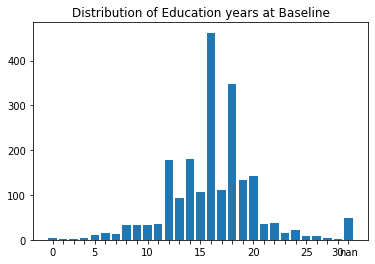

In [23]:
socio = pd.read_csv(os.path.join(data_dir, "Socio-Economics.csv"))[
    ["PATNO", "EVENT_ID", "EDUCYRS"]
]

socio = socio[socio["EVENT_ID"] == "SC"]
socio = socio.drop(["EVENT_ID"], axis=1)


fig, ax = plt.subplots()
dist = socio.groupby(["EDUCYRS"], dropna=False).size()
plt.bar(dist.index.astype(str), dist.values)
plt.title("Distribution of Education years at Baseline")

reformat_plot_labels(dist, ax, 5)

## Data aggregation

We merge the data ingested above to obtain a set of data with available
- MRI image
- Disease duration
- Cognitive and PD State
- UPDRS III, MoCA, and MMSE scores
- Socio-economic and demographic data

In [24]:
keys = ["PATNO", "EVENT_ID"]
df = (
    mri.merge(cog_state, on=keys)
    .merge(age, on=keys)
    .merge(demo, on=["PATNO"])
    .merge(socio, on=["PATNO"])
    .merge(updrs3, on=keys)
    .merge(moca, on=keys)
    .merge(pdxdur, on=keys)
    .drop_duplicates()
    .groupby("PATNO")
    .filter(lambda g: g["EVENT_ID"].nunique() > 1)
)

nc_patno = df[df["COGSTATE"] == 1]["PATNO"]
mci_patno = df[df["COGSTATE"] == 2]["PATNO"]

<div class="alert alert-block alert-warning">
    <span style="font-weight: bold">Note:</span> Patients can transition from NC to MCI between visits.
</div>

In [25]:
print(f"Unique number of patients: {df['PATNO'].nunique()}")
print(f"Unique number of NC patients: {nc_patno.nunique()}")
print(f"Unique number of MCI patients: {mci_patno.nunique()}")

df.groupby(["COGSTATE", "EVENT_ID"])["PATNO"].nunique().rename({1: "NC", 2: "MCI"})

Unique number of patients: 251
Unique number of NC patients: 235
Unique number of MCI patients: 65


COGSTATE  EVENT_ID
NC        BL          133
          ST            7
          V04         123
          V06         163
          V08           1
          V10         114
MCI       BL            7
          ST            2
          V04          24
          V06          39
          V08           1
          V10          27
Name: PATNO, dtype: int64

<div class="alert alert-block alert-danger">
    <span style="font-weight: bold">Issue:</span> At any visit, the amount of patients with MCI is lower than in the initial study (36).
</div>

## Find acceptable visit pairs
The inital study assess subjects at baseline and a follow-up visit at 18 month.
</br>Here below, we find the pairs of visits with the largest amount of MCI subject.

In [26]:
from itertools import combinations

events = ["BL", "V04", "V06", "V08", "V10"]

print("Unique MCI subjects per visit pairs:")
for c in combinations(events, 2):
    v0 = set(df[(df["EVENT_ID"] == c[0]) & (df["COGSTATE"] == 2)]["PATNO"].values)
    v1 = set(df[(df["EVENT_ID"] == c[1])]["PATNO"].values)
    if len(v0 & v1):
        print(
            f"{c[0]:3} & {c[1]:3} = {len(v0 & v1):>3}"
            f" | Month difference: {visit2month[c[1]] - visit2month[c[0]]}"
        )

Unique MCI subjects per visit pairs:
BL  & V04 =   4 | Month difference: 12
BL  & V06 =   4 | Month difference: 24
BL  & V10 =   3 | Month difference: 48
V04 & V06 =  22 | Month difference: 12
V04 & V10 =   9 | Month difference: 36
V06 & V10 =  17 | Month difference: 24


The pairs of visit with 12 or 24 months of interval have the most amount of MCI patients.
</br>We will explore the possibility of using those time interval for our replication cohort.

## Cohort with follow-up after 12 months

In [27]:
def sample_cohort(df, /, *, n):
    _df = df.drop_duplicates(subset=["PATNO"])
    n = min(_df.index.size, n)
    return _df.sample(n=n, replace=False, random_state=1)
    return _df[_df.index.isin(sample)]

In [28]:
visit_pairs = find_visit_pairs(12)
visit_df = df.copy()
visit_df["NEXT_VISIT"] = visit_df["EVENT_ID"].map(visit_pairs)

visit_df = visit_df.merge(
    visit_df.drop(
        ["AGE_AT_VISIT", "SEX", "NEXT_VISIT", "EDUCYRS"],
        axis=1,
    ),
    left_on=[
        "PATNO",
        "NEXT_VISIT",
    ],
    right_on=[
        "PATNO",
        "EVENT_ID",
    ],
    suffixes=(None, "_NX"),
).drop_duplicates()

mci = sample_cohort(visit_df[visit_df["COGSTATE"] == 2], n=36)
nc_df = visit_df[
    (visit_df["COGSTATE"] == 1) & ~visit_df["PATNO"].isin(mci["PATNO"].unique())
]
nc = sample_cohort(nc_df[nc_df["PDTRTMNT"] == 1], n=64)
hc = sample_cohort(
    nc_df[(nc_df["PDTRTMNT"] == 0) & ~nc_df["PATNO"].isin(nc["PATNO"].unique())], n=37
)

print(
    f"""Total number of subjects: {visit_df['PATNO'].nunique()}

Unique number of:
  - HC subjects:     {hc['PATNO'].unique().size} (/37)
  - PD-NC subjects:  {nc['PATNO'].unique().size} (/64)
  - PD-MCI subjects: {mci['PATNO'].unique().size} (/36)
"""
)

Total number of subjects: 143

Unique number of:
  - HC subjects:     37 (/37)
  - PD-NC subjects:  59 (/64)
  - PD-MCI subjects: 24 (/36)



<div class="alert alert-block alert-danger">
    <span style="font-weight: bold">Issue:</span> With a follow-up after 12 months, the replication cohort is missing both PD-NC and PD-MCI patients.
</div>

## Cohort with follow-up after 24 months

In [29]:
visit_pairs = find_visit_pairs(24)
visit_df = df.copy()
visit_df["NEXT_VISIT"] = visit_df["EVENT_ID"].map(visit_pairs)

visit_df = visit_df.merge(
    visit_df.drop(
        ["AGE_AT_VISIT", "SEX", "NEXT_VISIT", "EDUCYRS"],
        axis=1,
    ),
    left_on=[
        "PATNO",
        "NEXT_VISIT",
    ],
    right_on=[
        "PATNO",
        "EVENT_ID",
    ],
    suffixes=(None, "_NX"),
).drop_duplicates()

mci_ = sample_cohort(visit_df[visit_df["COGSTATE"] == 2], n=36)
nc_df = visit_df[
    (visit_df["COGSTATE"] == 1) & ~visit_df["PATNO"].isin(mci["PATNO"].unique())
]
nc_ = sample_cohort(nc_df[nc_df["PDTRTMNT"] == 1], n=64)
hc_ = sample_cohort(
    nc_df[(nc_df["PDTRTMNT"] == 0) & ~nc_df["PATNO"].isin(nc["PATNO"].unique())], n=37
)

print(
    f"""Total number of subjects: {visit_df['PATNO'].nunique()}

Unique number of:
  - HC subjects:     {hc_['PATNO'].unique().size} (/37)
  - PD-NC subjects:  {nc_['PATNO'].unique().size} (/64)
  - PD-MCI subjects: {mci_['PATNO'].unique().size} (/36)
"""
)

Total number of subjects: 176

Unique number of:
  - HC subjects:     37 (/37)
  - PD-NC subjects:  64 (/64)
  - PD-MCI subjects: 20 (/36)



<div class="alert alert-block alert-danger">
    <span style="font-weight: bold">Issue:</span> With a follow-up after 24 months, the replication cohort is missing both PD-NC and PD-MCI patients.
</div>

<div class="alert alert-block alert-success">
    <span style="font-weight: bold">Solution:</span> The duration between baseline and the follow-up visit is important. Therefore, this rules out the option of combining patient from both potential cohort.
    Instead, we will perform data analysis on both cohort seperately for comparison with the inital study.
</div>

## Cohort Summary

We replicate the table from the initial study with the PPMI data for both of our replication cohorts.

In [30]:
from collections.abc import Iterable

import rich
from rich.console import Console
from rich.table import Table


def cohort_summary(*, hc, nc, mci, title):
    def gen_row(D, *, agg, col, f="4.1f", sep=" ± "):
        if not isinstance(agg, str) and isinstance(agg, Iterable):
            return [f"{sep}".join([f"{d.loc[a][col]:{f}}" for a in agg]) for d in D]
        else:
            return [f"{d.loc[agg][col]:{f}}" for d in D]

    def gender_ratio(df):
        male_count = df[df["SEX"] == 1]["PATNO"].nunique()
        return f"{male_count:.0f}, {male_count / df['PATNO'].nunique() * 100:.1f}%"

    D = [hc.describe(), nc.describe(), mci.describe()]

    table = Table(title=title, box=rich.box.SIMPLE_HEAVY, show_footer=True)

    table.add_column("Subject groups", footer="Values expressed as mean ± SD.")
    table.add_column("HC")
    table.add_column("PD-NC")
    table.add_column("PD-MCI")
    # table.add_column("[italic]p")  # TODO

    table.add_row("n", *gen_row(D, agg="count", col="PATNO", f=".0f"))
    table.add_row("Age (y)", *gen_row(D, agg=["mean", "std"], col="AGE_AT_VISIT"))
    table.add_row(
        "Age range", *gen_row(D, agg=["min", "max"], col="AGE_AT_VISIT", sep=" - ")
    )
    table.add_row(
        "Gender (male, %)", gender_ratio(hc), gender_ratio(nc), gender_ratio(mci)
    )
    table.add_row("Education (y)", *gen_row(D, agg=["mean", "std"], col="EDUCYRS"))
    table.add_row(
        "Disease duration (mo)", *gen_row(D, agg=["mean", "std"], col="PDXDUR")
    )
    # table.add_row("LEDD (mg/d) baseline", )  # TODO
    table.add_row("H&Y baseline", *gen_row(D, agg=["mean", "std"], col="NHY"))
    table.add_row("H&Y follow-up", *gen_row(D, agg=["mean", "std"], col="NHY_NX"))
    table.add_row("UPDRS III baseline", *gen_row(D, agg=["mean", "std"], col="NP3TOT"))
    table.add_row(
        "UPDRS III follow-up", *gen_row(D, agg=["mean", "std"], col="NP3TOT_NX")
    )
    table.add_row("MMSE baseline", *gen_row(D, agg=["mean", "std"], col="MMSETOT"))
    table.add_row("MMSE follow-up", *gen_row(D, agg=["mean", "std"], col="MMSETOT_NX"))
    table.add_row("MoCA baseline", *gen_row(D, agg=["mean", "std"], col="MCATOT"))
    table.add_row("MoCA follow-up", *gen_row(D, agg=["mean", "std"], col="MCATOT_NX"))

    console = Console()
    console.print(table)

In [31]:
cohort_summary(
    hc=hc,
    nc=nc,
    mci=mci,
    title="Demographic and clinical characteristics\n(12 months cohort)",
)

                  Demographic and clinical characteristics                  
                             (12 months cohort)                             
                                                                            
  Subject groups                   HC            PD-NC         PD-MCI       
 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 
  n                                37            59            24           
  Age (y)                          61.0 ± 10.9   61.8 ±  9.0   67.9 ±  7.8  
  Age range                        41.5 - 82.3   39.6 - 78.3   50.4 - 83.0  
  Gender (male, %)                 23, 62.2%     36, 61.0%     20, 83.3%    
  Education (y)                    15.5 ±  3.6   14.8 ±  3.0   14.5 ±  3.6  
  Disease duration (mo)             3.6 ±  2.6    4.1 ±  2.6    4.1 ±  3.6  
  H&Y baseline                      0.8 ±  1.0    1.7 ±  0.5    1.4 ±  0.9  
  H&Y follow-up                     1.0 ±  0.9    1.7 ±  0.6    1.3 ±  1.0  
  UPDRS III baseline               10.7 ± 11.7   20.3 ±  9.3   15.7 ± 11.8  
  UPDRS III follow-up              13.6 ± 13.2   20.9 ±  9.9   19.1 ± 15.1  
  MMSE baseline                    29.4 ±  0.7   29.3 ±  1.0   28.0 ±  1.2  
  MMSE follow-up                   29.1 ±  1.3   29.3 ±  0.9   28.2 ±  1.5  
  MoCA baseline                    27.6 ±  1.7   27.4 ±  2.1   24.9 ±  2.2  
  MoCA follow-up                   27.2 ±  2.6   27.4 ±  2.1   25.5 ±  2.9  
 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 
  Values expressed as mean ± SD.                                           

In [32]:
cohort_summary(
    hc=hc_,
    nc=nc_,
    mci=mci_,
    title="Demographic and clinical characteristics\n(24 months cohort)",
)

                  Demographic and clinical characteristics                  
                             (24 months cohort)                             
                                                                            
  Subject groups                   HC            PD-NC         PD-MCI       
 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 
  n                                37            64            20           
  Age (y)                          62.1 ±  8.6   62.8 ±  8.7   66.1 ±  8.4  
  Age range                        45.9 - 84.3   40.4 - 77.5   49.9 - 79.2  
  Gender (male, %)                 21, 56.8%     38, 59.4%     17, 85.0%    
  Education (y)                    16.8 ±  4.3   15.7 ±  3.1   15.0 ±  3.0  
  Disease duration (mo)             5.4 ±  3.6    4.5 ±  2.7    5.1 ±  3.1  
  H&Y baseline                      0.5 ±  0.8    1.8 ±  0.5    1.9 ±  0.5  
  H&Y follow-up                     0.6 ±  0.8    2.0 ±  0.6    1.9 ±  0.8  
  UPDRS III baseline                8.5 ± 12.2   22.7 ± 10.3   25.2 ± 11.4  
  UPDRS III follow-up               9.0 ± 13.1   25.0 ± 13.1   26.2 ± 14.5  
  MMSE baseline                    29.4 ±  0.7   29.5 ±  0.8   28.5 ±  0.7  
  MMSE follow-up                   29.3 ±  1.1   29.5 ±  0.9   28.3 ±  1.4  
  MoCA baseline                    27.6 ±  1.7   27.7 ±  1.9   25.6 ±  1.6  
  MoCA follow-up                   27.4 ±  2.3   27.8 ±  1.9   25.2 ±  2.6  
 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 
  Values expressed as mean ± SD.                                           